# Mapping a Network of LPUs onto Multiple GPUs

This notebook illustrates how to connect and execute several generic LPUs on multiple GPUs.

### Background

Neurokernel's architecture enables one to specify complex networks of LPUs that interact via different connectivity patterns and map the LPUs to individual GPUs. This functionality is essential both to express models of the entire fly brain in terms of their constituent processing units and to the development of future resource allocation mechanisms that will be able to take advantage of available GPU resources in an automated manner.

<img src='files/files/lpu-network.jpg' />

### Constructing an LPU Network

Since each LPU instance in a multi-LPU model must possess a unique identifier, construction of an LPU network is a matter of instantiating connectivity patterns between those pairs of LPUs that one wishes to connect and populating them with data describing the connections between ports exposed by the respective LPUs.

In the example below, we first create an input signal and instantiate N generic LPUs containing fixed numbers of local and projection neurons. Each LPU is configured to run on a different GPU (where the at least N GPUs are assumed to be available). Notice that only one LPU receives the input signal:

In [1]:
import itertools
import random
import numpy as np
import sys
sys.path.append("../examples/multi/data")

import gen_generic_lpu as g

import neurokernel.core_gpu as core_gpu
from neurokernel.tools.zmq import get_random_port

import neurokernel.pattern as pattern
import neurokernel.plsel as plsel
from neurokernel.LPU.LPU import LPU

from neurokernel.LPU.InputProcessors.FileInputProcessor import FileInputProcessor
from neurokernel.LPU.OutputProcessors.FileOutputProcessor import FileOutputProcessor

# Execution parameters:
dt = 1e-4
dur = 1.0
start = 0.3
stop = 0.6
I_max = 0.6
steps = int(dur/dt)

N_sensory = 30  # number of sensory neurons
N_local = 30    # number of local neurons
N_output = 30   # number of projection neurons
N = 3           # number of LPUs

#Settings:
debug = False
time_sync = False

# Only LPU 0 receives input and should therefore be associated with a population                                   
# of sensory neurons:  
neu_dict = {i: [0, N_local, N_output] for i in xrange(N)}

# Only LPU 0 receives input and should therefore be associated with a population
# of sensory neurons:
neu_dict[0][0] = N_sensory

# Initialize RNG:
random.seed(0)
np.random.seed(0)

# Create input signal for LPU 0:
in_file_name_0 = 'generic_input.h5'
g.create_input(in_file_name_0, neu_dict[0][0], dt, dur, start, stop, I_max)

# Store info for all instantiated LPUs in the following dict:
lpu_dict = {}

# Set up several LPUs:
man = core_gpu.Manager()
for i, neu_num in neu_dict.iteritems():
    
    #Initialize the lpu entry
    lpu_entry = {}
    

    #First LPU is fed the input data
    if i == 0:
        print("Processing LPU: %d" % i)
        in_file_name = in_file_name_0
        fl_input_processors = [FileInputProcessor(in_file_name)]
    else:
        print("Processing LPU: %d" % i)
        in_file_name = None
        fl_input_processors = []
    
    
    lpu_file_name = 'generic_lpu_%s.gexf.gz' % i

    out_file_name = 'generic_lpu_%s_output.h5' % i
    
    fl_output_processors = [FileOutputProcessor(
                    [('V',None),('spike_state',None)],
                    out_file_name, sample_interval=1)]

    id = 'lpu_%s' % i

    g.create_lpu(lpu_file_name, id, *neu_num)
    (comp_dict, conns) = LPU.lpu_parser(lpu_file_name)

    man.add(LPU, id, dt, comp_dict, conns,
            input_processors = fl_input_processors,
            output_processors = fl_output_processors,
            device = i,
            debug = debug, time_sync = time_sync)

    print("id: %s, in_file_name: %s" % (id,in_file_name))
    lpu_entry['lpu_file_name'] = lpu_file_name
    lpu_entry['in_file_name'] = in_file_name
    lpu_entry['out_file_name'] = out_file_name
    lpu_entry['comp_dict'] = comp_dict
    lpu_entry['conns'] = conns

    lpu_dict[id] = lpu_entry

Processing LPU: 0
id: lpu_0, in_file_name: generic_input.h5
Processing LPU: 1
id: lpu_1, in_file_name: None
Processing LPU: 2
id: lpu_2, in_file_name: None


Each LPU exposes input and output communication ports. The generic LPU generator invoked above associates an output port with each projection neuron in an LPU and an input port with a node connected to a synapse that is in turn connected to some neuron in the LPU.

Once the LPUs have been instantiated, we use information about the ports exposed by each LPU to define connectivity patterns between those LPUs we wish to connect. Notice that since the ``Pattern`` class enables one to specify connections in both directions between two LPUs, it is only necessary to consider combinations of LPUs without regard to their order. In the example below, we define connections between all pairs of LPUs in the network, i.e., the graph of all LPUs is complete, and we only connect spiking neurons exposed by the LPUs:

In [2]:
# Since each connectivity pattern between two LPUs contains the synapses in both
# directions, create connectivity patterns between each combination of LPU
# pairs:
for id_0, id_1 in itertools.combinations(lpu_dict.keys(), 2):

    comp_dict_0 = lpu_dict[id_0]['comp_dict']
    comp_dict_1 = lpu_dict[id_1]['comp_dict']

    # Find all output and input port selectors in each LPU:
    out_ports_spk_0 = plsel.Selector(','.join(LPU.extract_out_spk(comp_dict_0, 'id')[0]))
    out_ports_gpot_0 = plsel.Selector(','.join(LPU.extract_out_gpot(comp_dict_0, 'id')[0]))

    out_ports_spk_1 = plsel.Selector(','.join(LPU.extract_out_spk(comp_dict_1, 'id')[0]))
    out_ports_gpot_1 = plsel.Selector(','.join(LPU.extract_out_gpot(comp_dict_1, 'id')[0]))

    in_ports_spk_0 = plsel.Selector(','.join(LPU.extract_in_spk(comp_dict_0, 'id')[0]))
    in_ports_gpot_0 = plsel.Selector(','.join(LPU.extract_in_gpot(comp_dict_0, 'id')[0]))

    in_ports_spk_1 = plsel.Selector(','.join(LPU.extract_in_spk(comp_dict_1, 'id')[0]))
    in_ports_gpot_1 = plsel.Selector(','.join(LPU.extract_in_gpot(comp_dict_1, 'id')[0]))

    out_ports_0 = plsel.Selector.union(out_ports_spk_0, out_ports_gpot_0)
    out_ports_1 = plsel.Selector.union(out_ports_spk_1, out_ports_gpot_1)

    in_ports_0 = plsel.Selector.union(in_ports_spk_0, in_ports_gpot_0)
    in_ports_1 = plsel.Selector.union(in_ports_spk_1, in_ports_gpot_1)

    # Initialize a connectivity pattern between the two sets of port
    # selectors:
    pat = pattern.Pattern(plsel.Selector.union(out_ports_0, in_ports_0),
                          plsel.Selector.union(out_ports_1, in_ports_1))

    # Create connections from the ports with identifiers matching the output
    # ports of one LPU to the ports with identifiers matching the input
    # ports of the other LPU. First, define connections from LPU0 to LPU1:
    N_conn_spk_0_1 = min(len(out_ports_spk_0), len(in_ports_spk_1))
    N_conn_gpot_0_1 = min(len(out_ports_gpot_0), len(in_ports_gpot_1))
    for src, dest in zip(random.sample(out_ports_spk_0.identifiers,
                                       N_conn_spk_0_1),
                         random.sample(in_ports_spk_1.identifiers,
                                       N_conn_spk_0_1)):
        pat[src, dest] = 1
        pat.interface[src, 'type'] = 'spike'
        pat.interface[dest, 'type'] = 'spike'
    for src, dest in zip(random.sample(out_ports_gpot_0.identifiers,
                                       N_conn_gpot_0_1),
                         random.sample(in_ports_gpot_1.identifiers,
                                       N_conn_gpot_0_1)):
        pat[src, dest] = 1
        pat.interface[src, 'type'] = 'gpot'
        pat.interface[dest, 'type'] = 'gpot'

    # Next, define connections from LPU1 to LPU0:
    N_conn_spk_1_0 = min(len(out_ports_spk_1), len(in_ports_spk_0))
    N_conn_gpot_1_0 = min(len(out_ports_gpot_1), len(in_ports_gpot_0))
    for src, dest in zip(random.sample(out_ports_spk_1, N_conn_spk_1_0),
                         random.sample(in_ports_spk_0, N_conn_spk_1_0)):
        pat[src, dest] = 1
        pat.interface[src, 'type'] = 'spike'
        pat.interface[dest, 'type'] = 'spike'
    for src, dest in zip(random.sample(out_ports_gpot_1, N_conn_gpot_1_0),
                         random.sample(in_ports_gpot_0, N_conn_gpot_1_0)):
        pat[src, dest] = 1
        pat.interface[src, 'type'] = 'gpot'
        pat.interface[dest, 'type'] = 'gpot'

    man.connect(id_0, id_1, pat, 0, 1)

Once all of the connections are in place, the entire network may be executed as follows:

In [3]:
from neurokernel.tools.mpi_run import mpi_run_manager
from subprocess import CalledProcessError
try:
    output = mpi_run_manager(man, steps = steps, log = True)
except CalledProcessError:
    with open('neurokernel.log', 'r') as f:
        print f.read()
print(output)

#The mpi_run_manager above is only necessary for notebook use.
#For regular manager execution, use the following code:
#man.spawn()
#man.start(steps=args.steps)
#man.wait()

MPI_RUN_SUCCESS: MPI_Function



Finally, we generate plots that depict the model execution

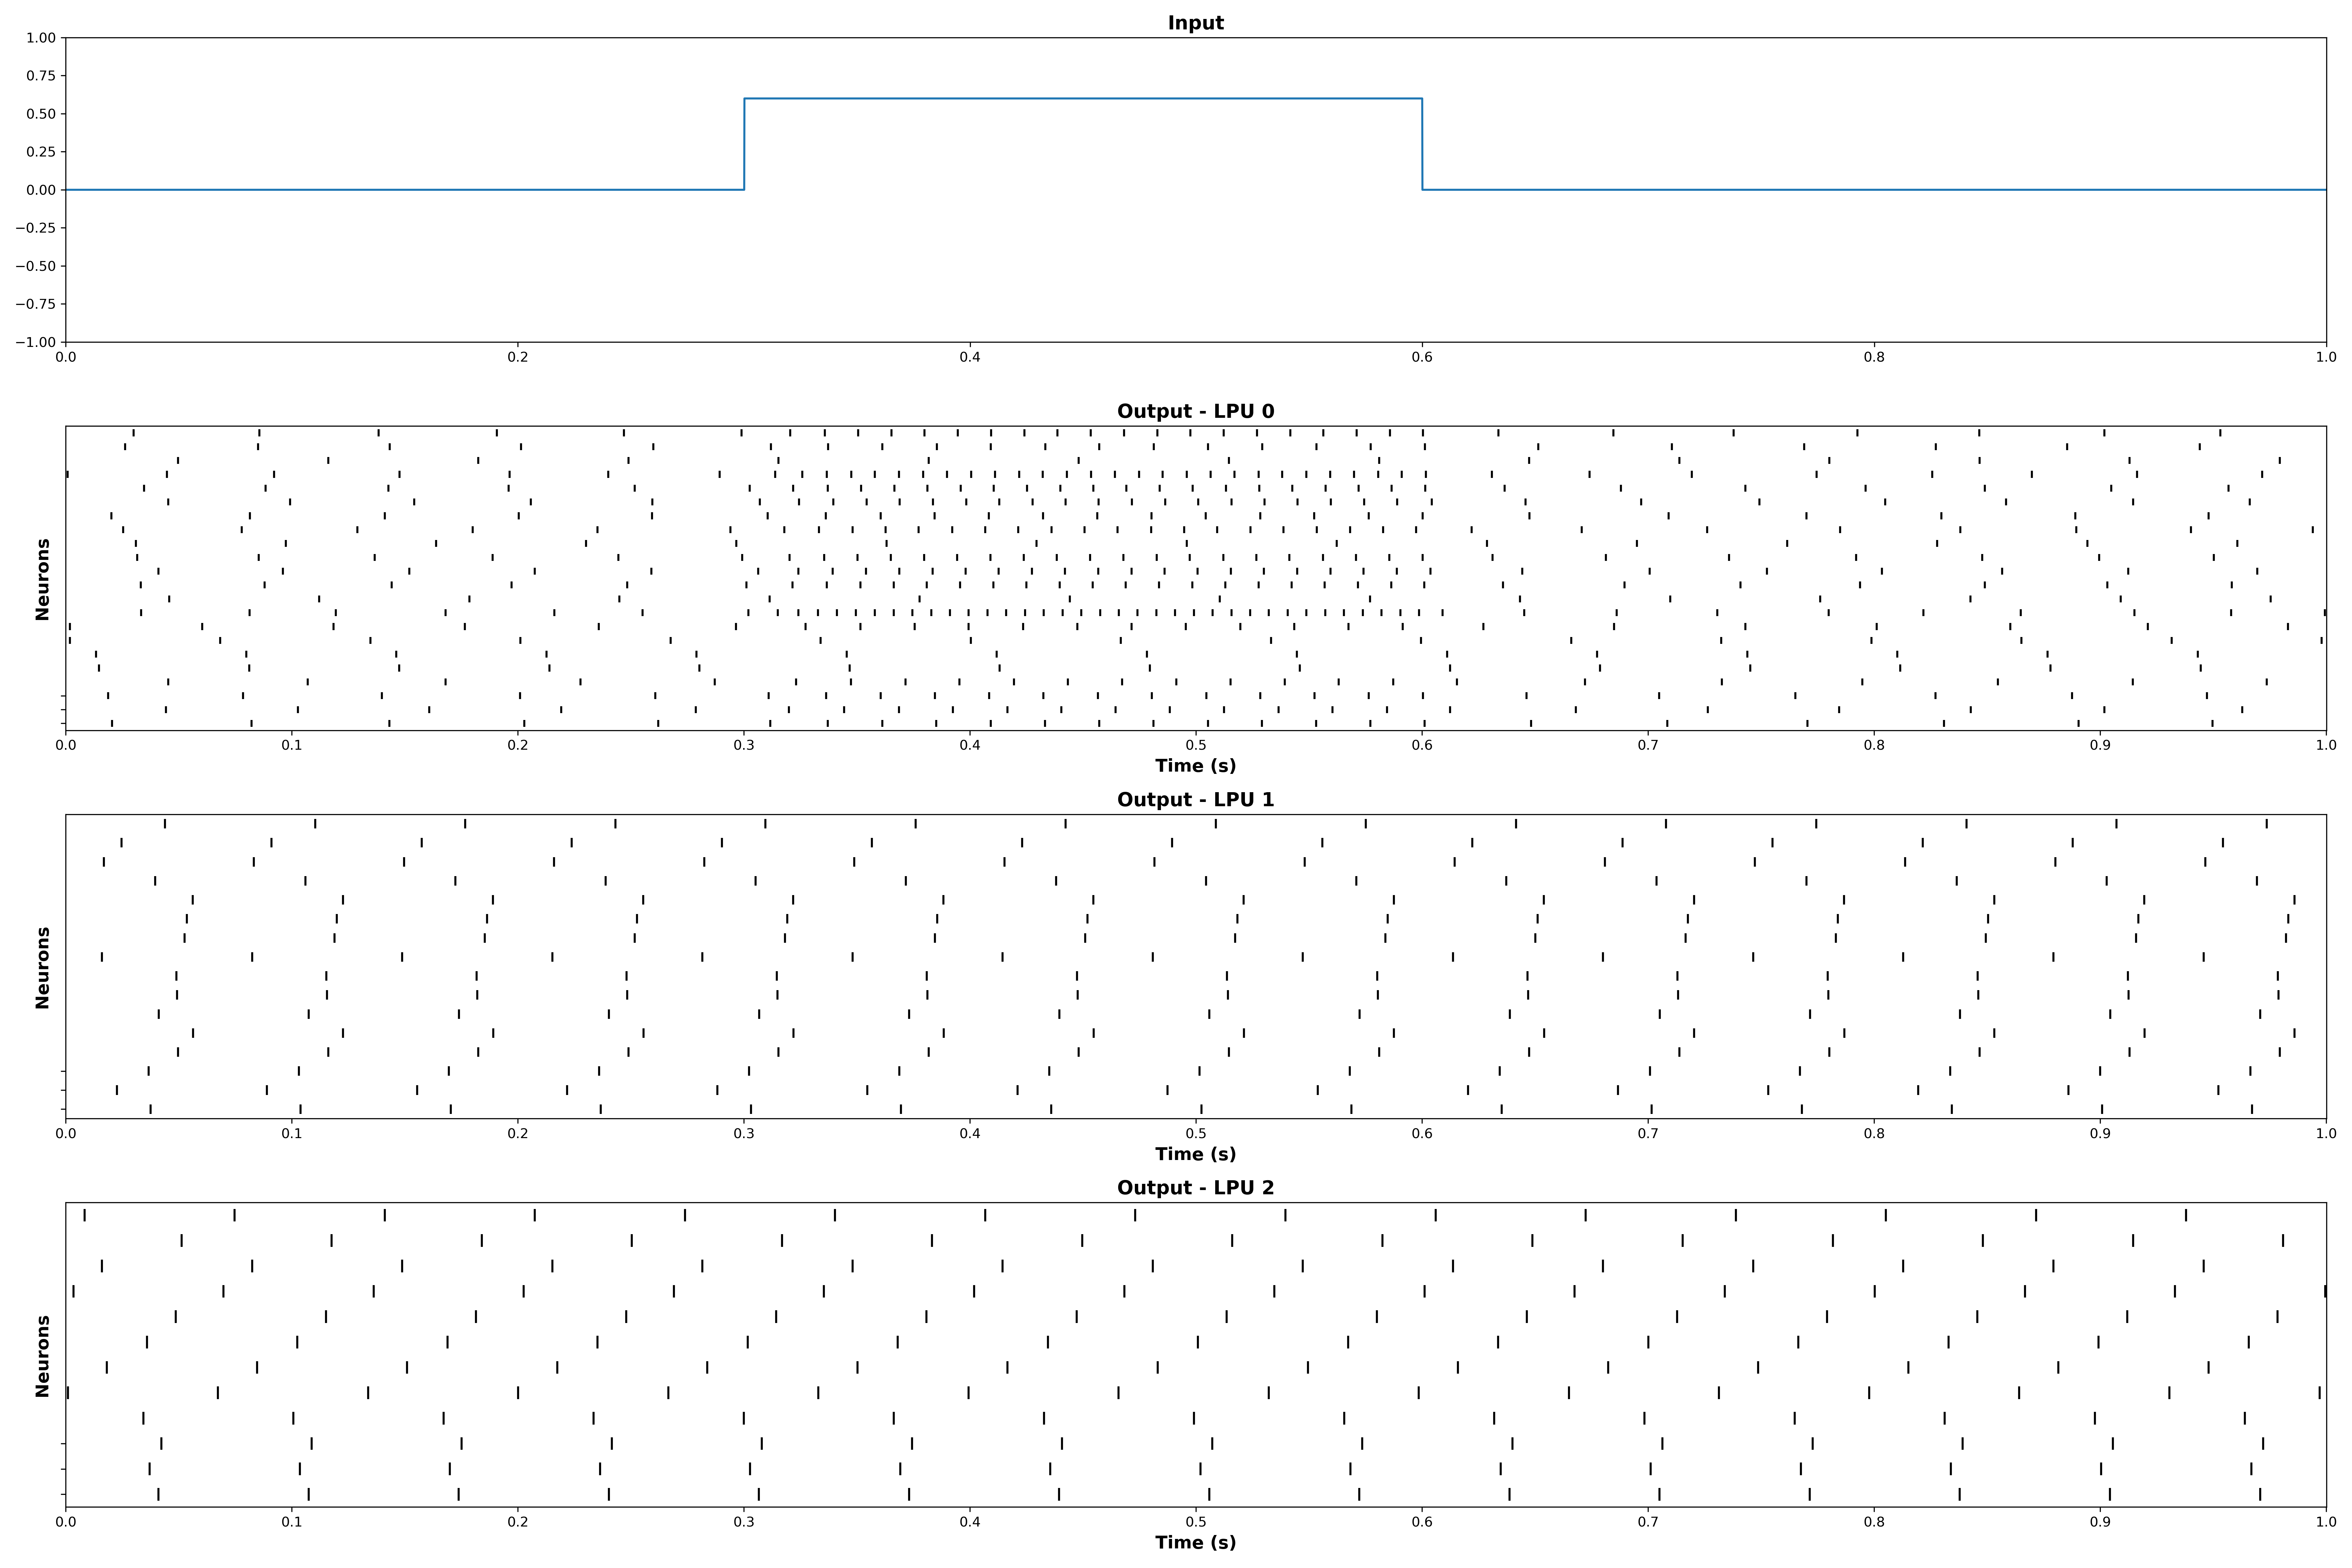

In [4]:
# Create input signal for LPU 0:
in_file_name_0 = 'generic_input.h5'
g.create_input(in_file_name_0, neu_dict[0][0], dt, dur, start, stop, I_max)

import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt

import neurokernel.LPU.utils.visualizer as vis
import networkx as nx
import h5py
from IPython.display import Image

# Temporary fix for bug in networkx 1.8:
nx.readwrite.gexf.GEXF.convert_bool = \
    {'false':False, 'False':False,
      'true':True, 'True':True}

V = vis.visualizer()

# create a plot for current input injected to 'neuron0'
V.add_LPU('generic_input.h5', LPU='Input', is_input = True, dt = dt)
V.add_plot({'type': 'waveform', 'uids': [['sensory_0']], 'variable': 'I', 'title': 'Input'}, 'input_Input')

for i in range(N):
    lpu_file_name = 'generic_lpu_%i.gexf.gz' % i

    out_file_name = 'generic_lpu_%i_output.h5' % i
    
    G = nx.read_gexf(lpu_file_name)    
    neu_proj = sorted([k for k, n in G.node.items() if \
                       n['name'][:4] == 'proj' and \
                       n['class'] == 'LeakyIAF'])    
    
    # create a plot for membrane potential output from 'neuron1'
    V.add_LPU(out_file_name,
              gexf_file= lpu_file_name, LPU='Simple LPU %i (Graded Potential)' % i, dt = dt)
    V.add_plot({'type': 'raster', 'uids': [neu_proj], 'variable': 'spike_state', 'title': 'Output - LPU %i' % i,
                'yticks': range(1,1+N),
                'yticklabels': ["" for _ in range(1,1+N)]},
                'Simple LPU %i (Graded Potential)' % i)

V._update_interval = None
V.rows = N + 1
V.cols = 1
V.fontsize = 14
V.dt = 0.01
V.xlim = [0, 1.0]
V.figsize = (24, 16)
V.run('multi_output.png')

# Don't automatically display the output image:
plt.close(plt.gcf())

Image(filename = 'multi_output.png')

The above demo can also be run in script form as follows. The parameters below specify a model comprising 30 sensory neurons connected to one LPU in a network of 3 LPUs connected to each other, each of which contains 30 local neurons and 30 output neurons:

In [ ]:
%run ../examples/multi/multi_demo.py -y 30 -n 30 -o 30 -u 3